# Reinforcement Learning Project: Control in a Continuous Action Space with DDPG

In this project, we will explore the Deep Deterministic Policy Gradient (DDPG) algorithm, which is designed to handle continuous action spaces in Reinforcement Learning. We will use the [Pendulum-v1](https://www.gymlibrary.dev/environments/classic_control/pendulum/) environment implemented in OpenAI Gym to implement the DDPG algorithm from scratch to solve the classical control problem of stabilizing an inverted pendulum. Throughout the development, we will incrementally build the components of DDPG and analyze their importance for correct and effective learning. 

This Jupyter notebook contains our implementation and report for this project. Do not forget to remove the report parts before submitting the notebook.

The instructions are available in `Miniproject_DDPG.pdf` file.

In [79]:
import numpy as np
from scipy import stats
import gym
from helpers import NormalizedEnv

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

from tqdm import tqdm


Seed

In [80]:
torch.manual_seed(42)
np.random.seed(42)

Global Instances

In [81]:
# Select device: 'cpu' or 'cuda'
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

# Create environement instance, an instance of the Pendulum-v1 environment wrapped in a NormalizedEnv class
# to normalize the action space between -1 and 1
env = gym.make('Pendulum-v1', render_mode='rgb_array')
env = NormalizedEnv(env)

# Number of steps per episode, see documentation of the Pendulum-v1 environment
n_steps = 200

Using device: cpu


# Toolbox

## Policies

In [82]:
# TODO docstring
class Agent:
    def __init__(self, env: NormalizedEnv) -> None:
        """Abstract agent class."""
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
class RandomAgent(Agent):
    def __init__(self, env: NormalizedEnv) -> None:
        super().__init__(env)
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        size = state.shape[:-1] + (self.action_size,)
        return np.random.uniform(-1, 1, size=size)
    
class HeuristicPendulumAgent(Agent):
    def __init__(self, env: NormalizedEnv, torque_intensity: float=1.0) -> None:
        super().__init__(env)
        self.torque_intensity = torque_intensity
        
    def compute_action(self, state: np.ndarray) -> np.ndarray:
        """Compute the action to apply to the environment.

        When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity.
        When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.
        """
        action = np.where(state[..., [0]] < 0, # If the pendulum is in the lower half of the circle
                        np.sign(state[..., [2]]) * self.torque_intensity, 
                        -np.sign(state[..., [2]]) * self.torque_intensity)
        return action

## Simulation

In [83]:
def compute_return_mean_std(agent: Agent, num_episodes: int = 10, env: NormalizedEnv = env) -> float:
    """Run the agent for `num_episodes` episodes and return the average return and its standard deviation."""
    returns = np.empty(num_episodes)
    for episode in range(num_episodes):
        state, _ = env.reset()
        cumulative_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state)
            state, reward, _, trunc, _ = env.step(action)
            cumulative_reward += reward
            if trunc:
                break
        returns[episode] = cumulative_reward
    return np.mean(returns), np.std(returns)

def animation(filename: str, agent: Agent, env: NormalizedEnv = env) -> None:
    """Run the agent for one episode and save the frames as a gif."""
    state, _ = env.reset()
    frames = []
    while True:
        action = agent.compute_action(state)
        state, _, _, trunc, _ = env.step(action)
        frames.append(env.render())
        if trunc:
            break

    frames = np.array(frames)
    frames = [Image.fromarray(frame) for frame in frames]
    frames[0].save(filename + ".gif", save_all=True, append_images=frames[1:], duration=50, loop=0)

## Replay Buffer

In [84]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        """Buffer to store transitions.

        A transition is a tuple (state, action, reward, next_state, trunc) where:
            state (np.ndarray[(3,), np.float32]): State of the environment.
            action (np.ndarray[(1,), np.float32]): Action applied to the environment.
            reward (np.ndarray[(1,), np.float32]): Reward obtained after applying the action.
            next_state (np.ndarray[(3,), np.float32]): State of the environment after applying the action.
            trunc (np.ndarray[(1,), np.bool]): Boolean indicating if the episode is truncated.
        
        The buffer is implemented as 5 (one for each element of a transition) cyclic numpy arrays of shape 
        (capacity, *) where * is the shape of the corresponding element of a transition.
        When the buffer is full, the oldest transitions are dropped.
        
        Args:
            capacity (int): Capacity of the buffer.
        """
        self.capacity = capacity 
        self.states = np.empty((capacity, 3), np.float32)
        self.actions = np.empty((capacity, 1), np.float32)
        self.rewards = np.empty((capacity, 1), np.float32)
        self.next_states = np.empty((capacity, 3), np.float32)
        self.truncs = np.empty((capacity, 1), bool)
        # Index of the next transition to be stored
        self.index = 0
        # Current size of the buffer
        self.size = 0

    def append(self, transition):
        """Add a transition to the buffer.
        
        See constructor docstring for explanation of a transition.
        """
        # Add transition to current index
        self.states[self.index] = transition[0]
        self.actions[self.index] = transition[1]
        self.rewards[self.index] = transition[2]
        self.next_states[self.index] = transition[3]
        self.truncs[self.index] = transition[4]
        # Update index
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        """Sample a batch of size `batch_size` of transitions from the buffers."""
        indexes = np.random.choice(self.size, batch_size, replace=False)
        return self[indexes]

    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, slice):
        return (self.states[slice], 
                self.actions[slice], 
                self.rewards[slice], 
                self.next_states[slice], 
                self.truncs[slice])


## Networks and Learning Rules

In [85]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int=env.observation_space.shape[0], action_size: int=env.action_space.shape[0]):
        """QNetwork. Maps (state, action) pairs to Q-values."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor
            action (torch.Tensor): Action tensor

        Returns:
            q_value (torch.Tensor): Q-value tensor
        """
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def TD_learning_update(q_network: QNetwork, 
                       agent: Agent, 
                       optimizer: torch.optim.Optimizer, 
                       transitions: tuple, 
                       gamma: float) -> float:
    """Perform a 1-step TD-learning update for a batch of transitions."""
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states)
        next_actions_t = torch.as_tensor(next_actions).to(device, dtype=torch.float32)
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [86]:
def train(agent: Agent,
          q_network: QNetwork, 
          q_optimizer: torch.optim.Optimizer,
          n_episodes: int=1000, 
          batch_size: int=128, 
          gamma: float=0.99, 
          logging_interval: int=10, 
          capacity: int=10000, 
          env: NormalizedEnv=env,
          n_steps: int=n_steps, 
          verbose: bool=True) -> np.ndarray:
    """Train the DDPG agent.

    Args:
        agent (Agent): Agent to train
        q_network (QNetwork): Q-network
        q_optimizer (torch.optim.Optimizer): Optimizer for the Q-network
        n_episodes (int, optional): Number of episodes to train for. Defaults to 1000.
        batch_size (int, optional): Batch size for training. Defaults to 128.
        gamma (float, optional): Discount factor. Defaults to 0.99.
        logging_interval (int, optional): Logging interval. Defaults to 10.
        capacity (int, optional): Capacity of the replay buffer. Defaults to 10000.
        env (NormalizedEnv, optional): Environment. Defaults to env.
        n_steps (int, optional): Number of steps per episode. Defaults to n_steps.
        verbose (bool, optional): Whether to print training logs. Defaults to True.
    
    Returns:
        losses (np.ndarray): Losses
    """
    replay_buffer = ReplayBuffer(capacity=capacity)
    losses = np.empty((n_episodes, n_steps))
    progress_bar = tqdm(range(n_episodes), desc="Training", disable=not verbose, unit="episode")
    with progress_bar as episodes:
        for episode in episodes:
            state, _ = env.reset()
            step = 0
            while True:
                # Simulation step
                action = agent.compute_action(state)
                next_state, reward, _, trunc, _ = env.step(action)
                transition = (state, action, reward, next_state, trunc)
                replay_buffer.append(transition)
                # Training step
                if len(replay_buffer) >= batch_size:
                    transitions = replay_buffer.sample(batch_size)
                    loss = TD_learning_update(q_network, agent, q_optimizer, transitions, gamma)
                    losses[episode, step] = loss
                else:
                    losses[episode, step] = np.nan

                if trunc:
                    break
                state = next_state
                step += 1    
            episodes.set_postfix_str(f"Loss: {np.nanmean(losses[episode])}")
    return losses
    

# Assignment

## 3 Heuristic policy

In [87]:
random_agent = RandomAgent(env)
average_return, _ = compute_return_mean_std(random_agent, 10, env)
print('Average return over 10 episodes: {}'.format(average_return))

Average return over 10 episodes: -1354.8754049484498


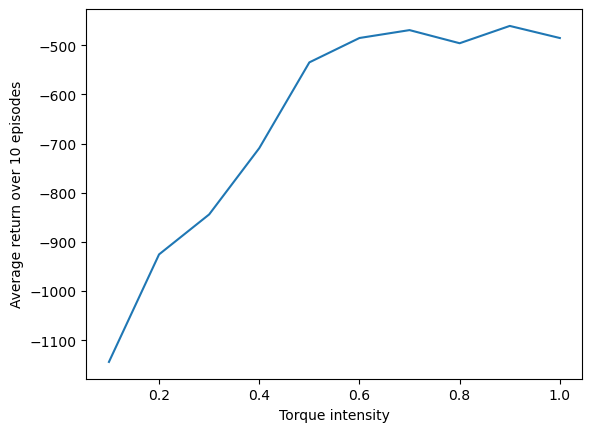

Best torque intensity: 0.9
Best return over 10 episodes: -460.54915813542686


In [88]:
# Find best torque intensity
torque_intensities = np.linspace(0.1, 1, 10)
average_returns = np.empty(len(torque_intensities))
for i, torque_intensity in enumerate(torque_intensities):
    heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensity)
    average_returns[i], _ = compute_return_mean_std(heuristic_agent, 10, env)

plt.plot(torque_intensities, average_returns)
plt.xlabel('Torque intensity')
plt.ylabel('Average return over 10 episodes')
plt.show()

# Create a HeuristicPendulumAgent with the best torque intensity
heuristic_agent = HeuristicPendulumAgent(env, torque_intensity=torque_intensities[np.argmax(average_returns)])
# Print best reward over 10 episodes and associated torque intensity
print('Best torque intensity: {}'.format(torque_intensities[np.argmax(average_returns)]))
print('Best return over 10 episodes: {}'.format(np.max(average_returns)))


The environment consists of a pendulum attached to a fixed pivot point. Its position is described by the angle $\alpha$ between the pendulum and the upward vertical direction, and its (angular) velocity is $\dot{\alpha}$. The pendulum is actuated by applying a torque $\tau$ on its pivot point (the action space is thus continuous). The pendulum is subject to gravity, which is the only external force acting on it.

The pendulum starts in a random position, with a random velocity and the aim is to stabilize it in the inverted position, using little torque. More precisely, we want to maximise cummulative reward $-\left(\alpha^2 + 0.1\dot{\alpha}^2 + 0.001\tau^2\right)$ over a time horizon of 200 steps. The pendulum starts in a random position, with a random velocity.

First we will compare two policies: a random policy and a heuristic policy. 
The random policy is a policy that selects actions uniformly at random from the action space, i.e. it applies a tork of random magnitude (within the allowed range)in a random direction.
The heuristic policy is defined as follows:
- When the pendulum is in the lower half of the domain, applies a fixed torque in the same direction as the pendulum's angular velocity;
- When the pendulum is in the upper half of the domain, applies a fixed torque in the opposite direction as the pendulum's angular velocity.

The average return over 10 episodes for the random policy is $\sim (-1300)$, which sets a baseline for the performance of the policies.

On Fig. 1, we see the average return over 10 episodes for the heuristic policy depending on the magnitude of the fixed torque. We can see that the heuristic policy performs better than the random policy for all values of the fixed torque, starting from $\sim (-900)$ for a fixed torque of $0.1$, then increasing to $\sim (-500)$ for a fixed torque of $\sim 0.5$, and then plateauing around $\sim (-450)$ up to a fixed torque of $1$. The best performance lies on this plateau but its exact value varies from one run to another. TODO check the values depending on the seed


## 4 Q function of the heuristic policy

In [89]:
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
q_network_before_training = copy.deepcopy(q_network)
optimizer = torch.optim.SGD(q_network.parameters(), lr=1e-4)
losses = train(heuristic_agent, 
               q_network, 
               optimizer, 
               n_episodes=1000, 
               batch_size=128, 
               gamma=0.99, 
               logging_interval=10, 
               capacity=10000, 
               env=env, 
               n_steps=n_steps, 
               verbose=True)


Training: 100%|██████████| 1000/1000 [10:25<00:00,  1.60episode/s, Loss: 69.49929655551911]


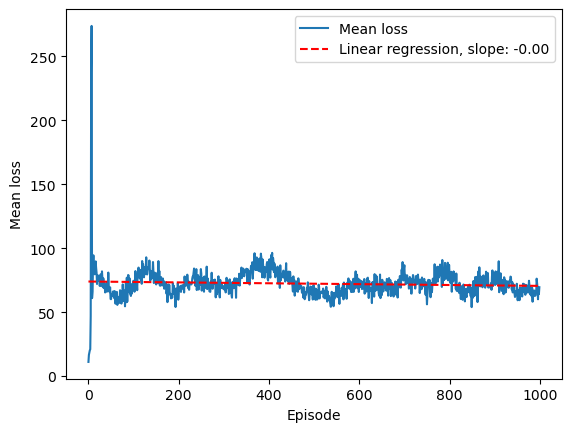

In [90]:
# Plot the mean loss per episode
plt.plot(np.nanmean(losses, axis=1))
# Add linear regression line
x = np.arange(losses.shape[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.nanmean(losses, axis=1))
plt.plot(x, slope*x + intercept, 'r--')

# Add legend and labels
plt.legend(['Mean loss', 'Linear regression, slope: {:.2f}'.format(slope)])
plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

(100, 100)


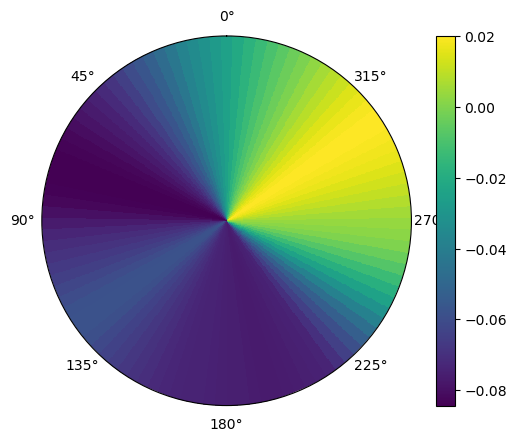

(100, 100)


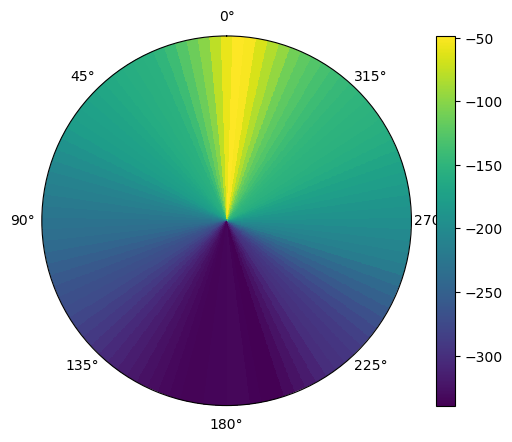

In [91]:
action = -1
velocity = 1

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
states = np.empty([100, 100, 3])
states[...,0] = np.cos(th)
states[...,1] = np.sin(th)
states[...,2] = np.full((100,100), velocity)

actions = np.full((100,100, 1), action)


#before training
z = q_network_before_training(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

#after training
z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

We now implement a critic, i.e. a Q-network, whose goal is to estimate the Q-function of the heuristic policy. We use a neural network with two hidden layers of 32 neurons each, with ReLU activation functions. It is updated using the semi-gradient of the mean squared error between the predicted and target Q-values.

On Fig. 2 we see the training curve with batches of size 128 and 1000 epochs. We can see that the training is very fast, with the loss decreasing to a value of $\sim 0.1$ after only 100 epochs. The loss then decreases very slowly, reaching a value of $\sim 0.05$ after 1000 epochs. This is due to the fact that the heuristic policy is deterministic, so the Q-values are constant and the critic can easily learn them.

 The training is done using the data generated by the heuristic policy, i.e. the states and the corresponding Q-values. The training is done over 1000 epochs, with a batch size of 64.

## 5 Minimal implementation of DDPG

In [92]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size: int=3, action_size: int=1):
        """PolicyNetwork. Maps states to actions."""
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        """Forward pass of the network.

        Args:
            state (torch.Tensor): State tensor

        Returns:
            action (torch.Tensor): Action tensor
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

In [93]:
class GaussianActionNoise:
    def __init__(self, sigma: float=0.3):
        assert(sigma>0), 'sigma must be positive'
        self.sigma = sigma

    def get_noisy_action(self, action: torch.Tensor):
        noise = torch.normal(mean=0, std=self.sigma, size=action.shape)
        return torch.clamp(action + noise, -1, +1)
    
class OUActionNoise:
    def __init__(self, theta: float=0.15, sigma: float=0.3):
        assert(theta>=0 and theta<=1), 'theta must be between 0 and 1 (included)'
        assert(sigma>=0), 'sigma must non-negative'
        self.theta = theta
        self.sigma = sigma
        self.noise = torch.zeros(env.action_space.shape[0])
        
    def get_noisy_action(self, action: torch.Tensor):
        self.noise = (1-self.theta)*self.noise + torch.normal(0, self.sigma, size=self.noise.shape)
        return torch.clamp(action + self.noise, -1, +1)


In [94]:
class DDPGAgent:
    def __init__(self, action_noise: 'ActionNoise'=GaussianActionNoise()):
        self.policy_network = PolicyNetwork().to(device)
        self.noise = action_noise
        
    def compute_action(self, state, deterministic=True):
        state_t = torch.from_numpy(state).to(device)
        action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action
    
def policy_learning_update(agent, optimizer, transitions, deterministic: bool=True):
    states = transitions[0]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    
    
    actions_t = agent.compute_action(states, deterministic)

    # Next Q-values (without taking truncation ??)
    qs = q_network(states_t, actions_t)

    loss = -qs.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [95]:
def train_ddpg(agent, q_network, optimizer_q, optimizer_policy, n_episodes: int=1000, 
               batch_size: int=128, gamma: float=0.99, logging_interval: int=10, 
               capacity: int=10000):
    """Train the DDPG agent.

    Args:
        agent (DDPGAgent): The agent to train.
        q_network (QNetwork): The Q-network to train.
        optimizer_q (torch.optim.Optimizer): The optimizer for the Q-network.
        optimizer_policy (torch.optim.Optimizer): The optimizer for the policy network.
        n_episodes (int, optional): Number of episodes to train. Defaults to 1000.
        batch_size (int, optional): Batch size for the TD-learning update. Defaults to 128.
        gamma (float, optional): Discount factor. Defaults to 0.99.
        logging_interval (int, optional): Logging interval. Defaults to 10.
        capacity (int, optional): Capacity of the replay buffer. Defaults to 10000.
    
    Returns:
        (np.ndarray, np.ndarray, np.ndarray): The losses of the Q-network, the losses of the policy network and the episode rewards.
    """
    # Number of steps per episode, see documentation of the Pendulum-v1 environment
    n_steps = 200
    replay_buffer = ReplayBuffer(capacity=capacity)
    # Container for the loss of each step of each episode
    losses_q = np.empty((n_episodes, n_steps))
    losses_policy = np.empty((n_episodes, n_steps))
    episode_rewards = np.empty(n_episodes)
    for episode in range(n_episodes):
        state, _ = env.reset()
        step = 0
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state, deterministic=False).detach().numpy()
            next_state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            replay_buffer.append((state, action, reward, next_state, trunc))
            # Training step
            if len(replay_buffer) >= batch_size:
                transitions = replay_buffer.sample(batch_size)
                loss_q = TD_learning_update(q_network, agent, optimizer_q, transitions, gamma)
                losses_q[episode, step] = loss_q
                # TODO ask deterministic or not
                loss_policy = policy_learning_update(agent, optimizer_policy, transitions, deterministic=False)
                losses_policy[episode, step] = loss_policy.item()
            else:
                losses_q[episode, step] = np.nan
                losses_policy[episode, step] = np.nan

            if trunc:
                break
            state = next_state
            step += 1
        episode_rewards[episode] = episode_reward
        # Logging average loss of the last episode every `logging_interval` episodes
        if episode % logging_interval == 0 and episode > 0:
            print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')

    return losses_q, losses_policy, episode_rewards



In [96]:
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
q_network_before_training = copy.deepcopy(q_network)
action_noise = GaussianActionNoise(sigma=0.3)
agent = DDPGAgent(action_noise=action_noise)
optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)

losses_q, losses_policy, episode_rewards = train_ddpg(
        agent, q_network, optimizer_q, optimizer_policy, n_episodes=300, batch_size=128, 
        gamma=0.99, capacity=10000, logging_interval=10)

Episode 10/299, average loss q-network: 1027.8240119934082, average loss policy network: 428.12833450317385
Episode 20/299, average loss q-network: 792.429899482727, average loss policy network: 388.0922850036621
Episode 30/299, average loss q-network: 902.2915070629119, average loss policy network: 426.6370973205566
Episode 40/299, average loss q-network: 776.1396857643127, average loss policy network: 380.14611709594726
Episode 50/299, average loss q-network: 831.6861450862884, average loss policy network: 386.28671249389646
Episode 60/299, average loss q-network: 866.0577660751343, average loss policy network: 397.7720629882813
Episode 70/299, average loss q-network: 929.0527426624299, average loss policy network: 434.6167379760742
Episode 80/299, average loss q-network: 893.7212569618225, average loss policy network: 445.4553611755371
Episode 90/299, average loss q-network: 1010.7371203613282, average loss policy network: 451.30565551757815
Episode 100/299, average loss q-network: 

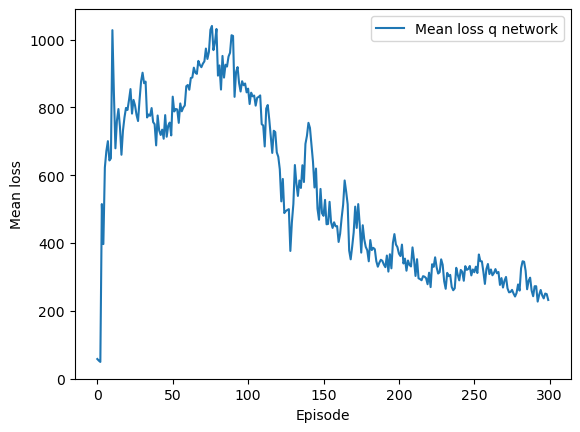

In [97]:
# Plot the mean loss of q network per episode
plt.plot(np.nanmean(losses_q, axis=1))

# legend
plt.legend(['Mean loss q network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

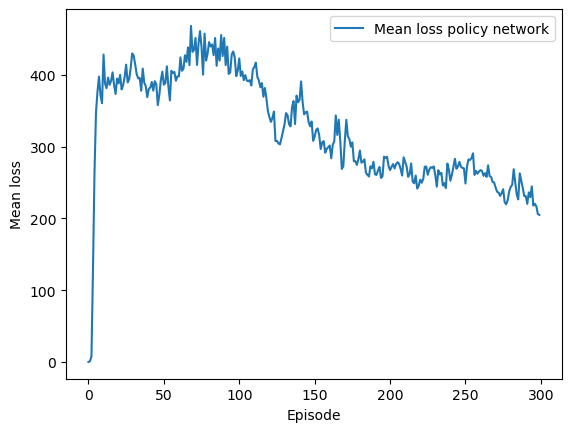

In [98]:
# Plot the mean loss of policy network per episode
plt.plot(np.nanmean(losses_policy, axis=1))

# legend
plt.legend(['Mean loss policy network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

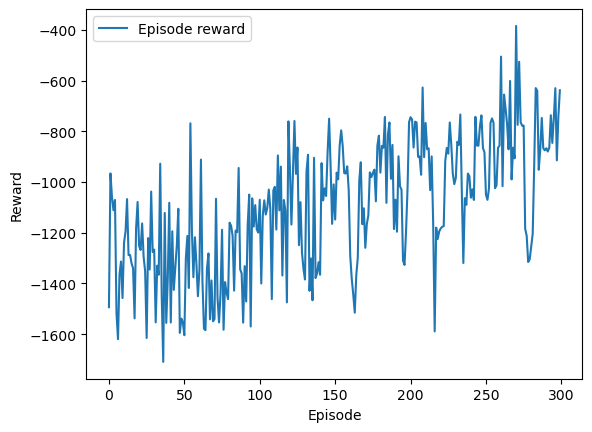

In [99]:
# Plot the episode reward for each episode
plt.plot(episode_rewards)

# legend
plt.legend(['Episode reward'])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [100]:
n_episodes = 100
episode_rewards = np.empty(n_episodes)
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    while True:
        action = agent.compute_action(state, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        if trunc:
            break
        state = next_state

    episode_rewards[episode] = episode_reward

print('Average reward over 100 episodes: {}'.format(np.mean(episode_rewards)))

Average reward over 100 episodes: -743.2948198382628


(100, 100)


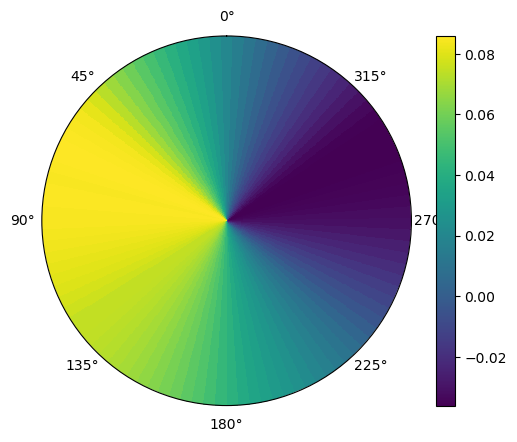

(100, 100)


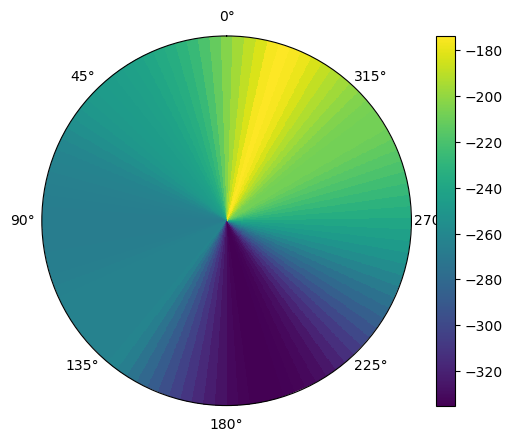

In [101]:
action = -1
velocity = 2

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
states = np.empty([100, 100, 3])
states[...,0] = np.cos(th)
states[...,1] = np.sin(th)
states[...,2] = np.full((100,100), velocity)

actions = np.full((100,100, 1), action)


#before training
z = q_network_before_training(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

#after training
z = q_network(torch.Tensor(states), torch.Tensor(actions)).detach().squeeze()

print(np.array(z).shape)


fig = plt.figure()

rad = np.linspace(0, 5, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)

ax = plt.subplot(projection="polar")
ax.set_theta_zero_location('N')

ax.set_yticklabels([])

p = plt.pcolormesh(th, r, z)
fig.colorbar(p)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()

plt.show()

In [102]:
"""
transitions = replay_buffer.sample(batch_size)
velocities = transitions[0][:,2]
print(velocities.max())
#save model and losses
torch.save(q_network.state_dict(), "5_q_network.pt")
torch.save(agent.policy_network.state_dict(), "5_policy_network.pt")
np.save("5_q_loss.txt", losses_q)
np.save("5_policy_loss.txt", losses_policy)
np.save("5_rewards.txt", episode_rewards)
"""

'\ntransitions = replay_buffer.sample(batch_size)\nvelocities = transitions[0][:,2]\nprint(velocities.max())\n#save model and losses\ntorch.save(q_network.state_dict(), "5_q_network.pt")\ntorch.save(agent.policy_network.state_dict(), "5_policy_network.pt")\nnp.save("5_q_loss.txt", losses_q)\nnp.save("5_policy_loss.txt", losses_policy)\nnp.save("5_rewards.txt", episode_rewards)\n'

## 6. Target networks

In [103]:
class DDPGAgentWithTargetNetwork:
    def __init__(self, action_noise: 'ActionNoise'=GaussianActionNoise()):
        self.policy_network = PolicyNetwork().to(device)
        self.target_policy_network = copy.deepcopy(self.policy_network).to(device)
        self.target_policy_network = PolicyNetwork().to(device)
        self.target_policy_network.load_state_dict(self.policy_network.state_dict())
        self.noise = action_noise
        
    def compute_action(self, state, target=False, deterministic=True):
        state_t = torch.from_numpy(state).to(device)
        if target:
            action = self.target_policy_network(state_t)
        else:
            action = self.policy_network(state_t)
        if not deterministic:
            action = self.noise.get_noisy_action(action)
        return action

def policy_learning_update_with_target(agent, optimizer, transitions, deterministic: bool=True):
    states = transitions[0]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    
    
    actions_t = agent.compute_action(states, target=False, deterministic=deterministic)

    # Next Q-values (without taking truncation ??)
    qs = q_network(states_t, actions_t)

    loss = -qs.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [104]:
def TD_learning_update_with_target_networks(q_network, target_q_network, agent, optimizer, transitions, gamma):
    """Perform a 1-step TD-learning update for a batch of transitions.

    Args:
        q_network (QNetwork): QNetwork instance
        agent (Agent): Agent (i.e. Policy) instance
        optimizer (torch.optim): Optimizer instance
        transitions (List[Transition]): Batch of transitions
        gamma (float): Discount factor

    Returns:
        loss (float): Loss value
    """
    states = transitions[0]
    actions = transitions[1]
    rewards = transitions[2]
    next_states = transitions[3]
    truncs = transitions[4]

    # Convert the numpy arrays to torch tensors
    states_t = torch.from_numpy(states).to(device)
    actions_t = torch.from_numpy(actions).to(device)
    rewards_t = torch.from_numpy(rewards).to(device)
    next_states_t = torch.from_numpy(next_states).to(device)
    truncs_t = torch.from_numpy(truncs).to(device)


    with torch.no_grad():
        next_actions = agent.compute_action(next_states, target=True, deterministic=True)
        if not torch.is_tensor(next_actions):
            next_actions_t = torch.as_tensor(next_actions)[:, None].to(device, dtype=torch.float32)
        else: next_actions_t = next_actions
        # Naive next Q-values (i.e. without taking truncation into account)
        naive_next_qs = target_q_network(next_states_t, next_actions_t)
        # Actual next Q-values (i.e. taking truncation into account)
        next_qs = torch.where(truncs_t, 
                              torch.zeros_like(rewards_t), 
                              naive_next_qs)
        gamma = torch.tensor(gamma, dtype=torch.float32)
        targets = rewards_t + gamma * next_qs

    loss = F.mse_loss(q_network(states_t, actions_t), targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [105]:
def target_learning(network, target_network, tau):
    target_network_state_dict = target_network.state_dict()
    network_state_dict = network.state_dict()
    for key in network_state_dict:
        target_network_state_dict[key] = network_state_dict[key]*tau + target_network_state_dict[key]*(1-tau)
    target_network.load_state_dict(target_network_state_dict)

In [106]:
def train_ddpg_with_target(agent, q_network, target_q_network, optimizer_q, optimizer_policy, n_episodes: int=1000, 
               batch_size: int=128, gamma: float=0.99, logging_interval: int=10, 
               capacity: int=10000, tau: float=0.05):
    
    # Number of steps per episode, see documentation of the Pendulum-v1 environment
    n_steps = 200
    replay_buffer = ReplayBuffer(capacity=capacity)
    # Container for the loss of each step of each episode
    losses_q = np.empty((n_episodes, n_steps))
    losses_policy = np.empty((n_episodes, n_steps))
    episode_rewards = np.empty(n_episodes)
    logging_interval = 10
    for episode in range(n_episodes):
        state, _ = env.reset()
        step = 0
        episode_reward = 0
        while True:
            # Simulation step
            action = agent.compute_action(state, target=False, deterministic=False).detach().numpy()
            next_state, reward, _, trunc, _ = env.step(action)
            episode_reward += reward
            replay_buffer.append((state, action, reward, next_state, trunc))
            # Training step
            if len(replay_buffer) >= batch_size:
                transitions = replay_buffer.sample(batch_size)
                loss_q = TD_learning_update_with_target_networks(q_network, target_q_network, agent, optimizer_q, transitions, gamma)
                losses_q[episode, step] = loss_q.item()
                loss_policy = policy_learning_update_with_target(agent, optimizer_policy, transitions, deterministic=True)
                losses_policy[episode, step] = loss_policy.item()

                # Update of the target networks
                target_learning(q_network, target_q_network, tau=tau)
                target_learning(agent.policy_network, agent.target_policy_network, tau=tau)
            else:
                losses_q[episode, step] = np.nan
                losses_policy[episode, step] = np.nan

            if trunc:
                break
            state = next_state
            step += 1
        episode_rewards[episode] = episode_reward
        # Logging average loss of the last episode every `logging_interval` episodes
        if episode % logging_interval == 0 and episode > 0:
            print(f'Episode {episode}/{n_episodes-1}, average loss q-network: {np.mean(losses_q[episode])}, average loss policy network: {np.mean(losses_policy[episode])}')
    return losses_q, losses_policy, episode_rewards

In [107]:
q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
target_q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
target_q_network.load_state_dict(q_network.state_dict())
action_noise = GaussianActionNoise(sigma=0.3)
agent = DDPGAgentWithTargetNetwork(action_noise=action_noise)
optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)

# Training loop for the Q-learning
n_episodes = 400 # Number of episodes

losses_q, losses_policy, episode_rewards = train_ddpg_with_target(agent, q_network, target_q_network, optimizer_q, optimizer_policy,
                                                      n_episodes=n_episodes, batch_size=128, gamma=0.99, logging_interval=10,
                                                      capacity=10000, tau=0.07)

Episode 10/399, average loss q-network: 424.7539145565033, average loss policy network: 241.47115509033202
Episode 20/399, average loss q-network: 1163.8888859224319, average loss policy network: 386.1323815917969
Episode 30/399, average loss q-network: 1210.0782243251801, average loss policy network: 411.55455200195314
Episode 40/399, average loss q-network: 1293.5935996341705, average loss policy network: 403.6728025817871
Episode 50/399, average loss q-network: 955.4419764995575, average loss policy network: 380.4622836303711
Episode 60/399, average loss q-network: 1300.3321729373931, average loss policy network: 382.2776628112793
Episode 70/399, average loss q-network: 830.4603950023651, average loss policy network: 367.67486572265625
Episode 80/399, average loss q-network: 507.27039605140686, average loss policy network: 323.6937321472168
Episode 90/399, average loss q-network: 410.4163771104813, average loss policy network: 289.1696089172363
Episode 100/399, average loss q-networ

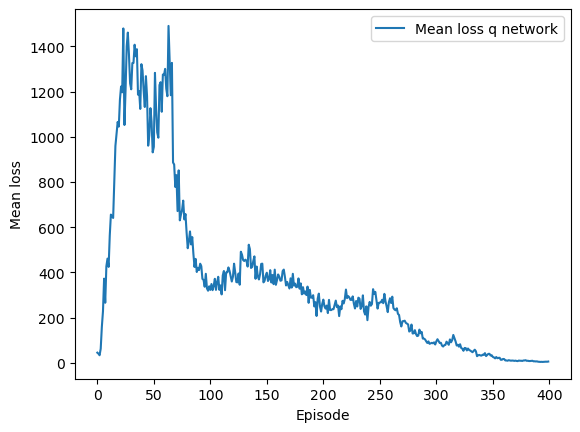

In [108]:
# Plot the mean loss of q network per episode
plt.plot(np.nanmean(losses_q, axis=1))

# legend
plt.legend(['Mean loss q network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()

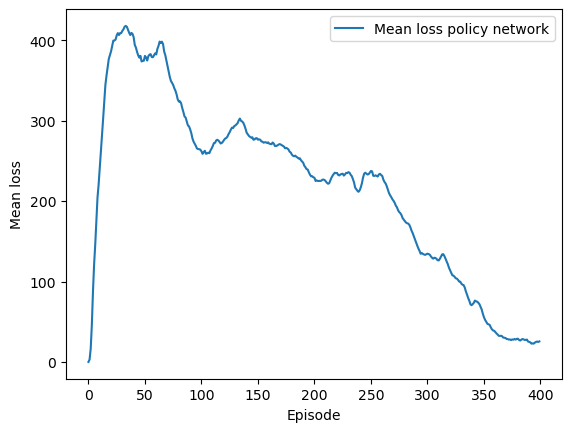

[[         nan          nan          nan ...   0.58976299   0.58844817
    0.631118  ]
 [  0.63564068   0.61394173   0.67459136 ...   6.94813967   7.30635071
    7.68178749]
 [  8.05605125   7.86492538   7.75555658 ...  25.04981613  28.05797195
   30.2684021 ]
 ...
 [231.45877075 224.03646851 235.92825317 ... 230.22706604 223.58364868
  234.56933594]
 [227.24736023 227.38806152 234.11831665 ... 231.92314148 228.13169861
  233.30929565]
 [235.30990601 235.18530273 222.09439087 ... 231.80198669 223.10540771
  238.85580444]]


In [109]:
# Plot the mean loss of policy network per episode
plt.plot(np.nanmean(losses_policy, axis=1))

# legend
plt.legend(['Mean loss policy network'])

plt.xlabel('Episode')
plt.ylabel('Mean loss')
plt.show()
print(losses_policy[:200])

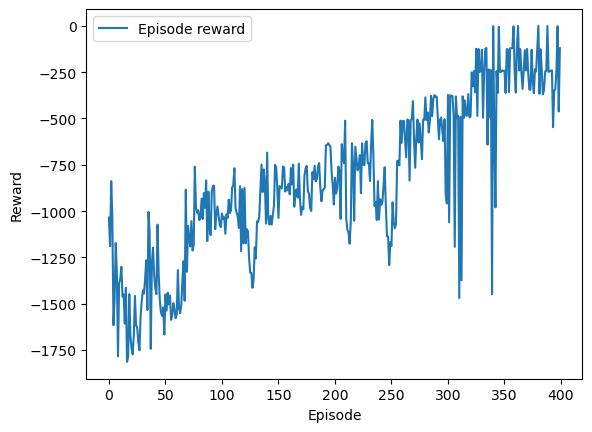

In [110]:
# Plot the episode reward for each episode
plt.plot(episode_rewards)

# legend
plt.legend(['Episode reward'])

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [111]:
n_episodes = 100
episode_rewards = np.empty(n_episodes)
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    while True:
        action = agent.compute_action(state, target=False, deterministic=False).detach().numpy()
        next_state, reward, _, trunc, _ = env.step(action)
        episode_reward += reward
        if trunc:
            break
        state = next_state
        episode_rewards[episode] = episode_reward
        
        print('Average reward over 100 episodes: {}'.format(np.mean(episode_rewards)))

Average reward over 100 episodes: -0.0019498651049048566
Average reward over 100 episodes: -0.003054493353107682
Average reward over 100 episodes: -0.003991384319035011
Average reward over 100 episodes: -0.004959196221103021
Average reward over 100 episodes: -0.005972069753217156
Average reward over 100 episodes: -0.007020005612142916
Average reward over 100 episodes: -0.0080405833236372
Average reward over 100 episodes: -0.009089207729442847
Average reward over 100 episodes: -0.010195123795033427
Average reward over 100 episodes: -0.011300825259703516
Average reward over 100 episodes: -0.012454584798837851
Average reward over 100 episodes: -0.013611262614523587
Average reward over 100 episodes: -0.014748329827849063
Average reward over 100 episodes: -0.01585734804159465
Average reward over 100 episodes: -0.01697617689278492
Average reward over 100 episodes: -0.018116980070598476
Average reward over 100 episodes: -0.019417629246873003
Average reward over 100 episodes: -0.02073976690907

In [112]:
# Animation of the Heuristic Agent using PIL
"""
state, _ = env.reset()
frames = []
while True:
    action = agent.compute_action(state, target=False, deterministic=True).detach().numpy()
    state, reward, _, trunc, _ = env.step(action)
    frames.append(env.render())
    if trunc:
        break

frames = np.array(frames)
frames = [Image.fromarray(frame) for frame in frames]
frames[0].save("agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)
"""

'\nstate, _ = env.reset()\nframes = []\nwhile True:\n    action = agent.compute_action(state, target=False, deterministic=True).detach().numpy()\n    state, reward, _, trunc, _ = env.step(action)\n    frames.append(env.render())\n    if trunc:\n        break\n\nframes = np.array(frames)\nframes = [Image.fromarray(frame) for frame in frames]\nframes[0].save("agent.gif", save_all=True, append_images=frames[1:], duration=50, loop=0)\n'

# 7 Ornstein-Uhlenbeck noise

In [114]:
thetas = [0, 0.25, 0.5, 0.75, 1]
for theta in thetas:
    q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
    target_q_network = QNetwork(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0]).to(device)
    target_q_network.load_state_dict(q_network.state_dict())
    action_noise = OUActionNoise(theta=theta, sigma=0.3)
    agent = DDPGAgentWithTargetNetwork(action_noise=action_noise)
    optimizer_q = torch.optim.SGD(q_network.parameters(), lr=1e-4)
    optimizer_policy = torch.optim.SGD(agent.policy_network.parameters(), lr=1e-4)
    losses_q, losses_policy, episode_rewards = train_ddpg_with_target(
        agent, q_network, target_q_network, optimizer_q, optimizer_policy, n_episodes=100, batch_size=128, 
        gamma=0.99, capacity=10000, logging_interval=100)

Episode 10/99, average loss q-network: 5.77216338455677, average loss policy network: 18.538986558914186
Episode 20/99, average loss q-network: 32.45736289978027, average loss policy network: 59.96132616043091
Episode 30/99, average loss q-network: 205.47551292419433, average loss policy network: 131.0886322402954
Episode 40/99, average loss q-network: 77.38263637781144, average loss policy network: 103.5253931427002
Episode 50/99, average loss q-network: 63.146842722892764, average loss policy network: 91.08851806640625
Episode 60/99, average loss q-network: 61.22497534275055, average loss policy network: 97.60790050506591
Episode 70/99, average loss q-network: 99.93178411483764, average loss policy network: 114.32932300567627
Episode 80/99, average loss q-network: 57.24340687334538, average loss policy network: 98.02273700714112
Episode 90/99, average loss q-network: 50.64227136492729, average loss policy network: 88.33624885559082
Episode 10/99, average loss q-network: 330.666196079